In [1]:
import heeps
from heeps.util.multiCPU import multiCPU
from copy import deepcopy
import proper
import os.path
from astropy.io import fits
from scipy.signal import savgol_filter
import warnings
import matplotlib.pyplot as plt
from matplotlib.pylab import ScalarFormatter
from matplotlib import cm
%matplotlib inline

## Input parameters

In [2]:
dir_current = '$HOME/heeps_metis'
scao = 'input_files/wavefront/cube_Cbasic_20210504_600s_100ms_0piston_meters_scao_only_720_WV.fits'
mask = 'input_files/wavefront/mask_Cbasic_20210504_720.fits'
dir_current = os.path.normpath(os.path.expandvars(dir_current))
cube = fits.getdata(os.path.join(dir_current, scao))
pup = fits.getdata(os.path.join(dir_current, mask))
ncube, nimg, _ = cube.shape
t_max = 600                         # cube duration in s
nframes_spat_psd = 100              # number of frames for spatial PSD
nzers = 20                          # number of Zernike modes to fit
pol_order = 3                       # filter polynomial order
win_size = 51                       # filter window size

In [3]:
def get_piston(frame):
    return np.mean(frame[frame!=0])
def get_rms(frame):
    return np.std(frame[frame!=0])
def get_zpols(nzer, pup, phi):
    zpols = proper.prop_fit_zernikes(phi, pup, nimg/2, nzer, eps=0, fit=True)
    return zpols
def remove_zernike(wf, pup, phi, zpols):
    proper.prop_add_phase(wf, phi)
    phiz = proper.prop_zernikes(wf, np.arange(len(zpols)) + 1, zpols)
    phiz[pup==0] = 0
    phih = phi - phiz    
    return phiz, phih

## 1/ Zernike polynomials

In [4]:
zpols = multiCPU(get_zpols, posargs=[nzers, pup], posvars=[cube], case='get zpols')
wf = proper.prop_begin(nimg, 1, nimg, 1)

   2021-05-20 15:48:22, get zpols using 56 cores
   2021-05-20 16:28:41, completed in 2418.7 seconds


### Save cube: SCAO + QACITS

In [5]:
_, phih = multiCPU(remove_zernike, posargs=[deepcopy(wf), pup], posvars=[cube, zpols[:,:3]], \
    case='QACITS', nout=2, verbose=True)
fits.writeto(os.path.join(dir_current, 'scao_qacits.fits'), np.float32(phih), overwrite=True)

   2021-05-20 16:28:41, QACITS using 56 cores
   2021-05-20 16:33:27, completed in 286.64 seconds


### Save cube: SCAO + QACITS and PSI

In [6]:
freq = 10
zpols_psi = np.empty(zpols.shape)
for i in range(int(zpols.shape[0]/freq)):
    zpols_psi[i*freq:(i+1)*freq,:] = np.mean(zpols[i*freq:(i+1)*freq,:], 0)
zpols_psi[freq:,:] = zpols_psi[:-freq,:]
zpols_psi[:,:3] = zpols[:,:3]
_, phih = multiCPU(remove_zernike, posargs=[deepcopy(wf), pup], posvars=[cube, zpols_psi], \
    case='PSI', nout=2, verbose=True)
fits.writeto(os.path.join(dir_current, 'scao_qacits_psi.fits'), np.float32(phih), overwrite=True)

   2021-05-20 16:34:08, PSI using 56 cores
   2021-05-20 16:50:37, completed in 988.89 seconds


## 2/ Spatial PSD

remove zernikes: 20 simulations
   2021-05-20 16:51:36, remove zernike using 56 cores
   2021-05-20 16:53:07, completed in 91.37 seconds
   2021-05-20 16:53:09, get rms using 56 cores
   2021-05-20 16:54:20, completed in 70.56 seconds
   2021-05-20 16:54:20, get rms using 56 cores
   2021-05-20 16:55:14, completed in 53.98 seconds
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 

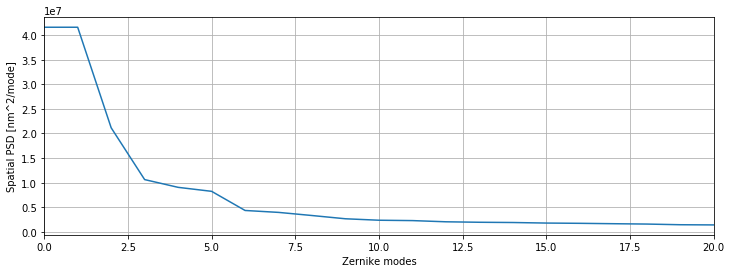

In [7]:
LSFs = np.empty((nzers, nframes_spat_psd, nimg, nimg))
HSFs = np.empty((nzers, nframes_spat_psd, nimg, nimg))
LSFs_rms = []
HSFs_rms = []
print('remove zernikes: %s simulations'%nzers)
for i,z in enumerate(np.arange(nzers)):
    verbose = False if i > 0 else True
    phiz, phih = multiCPU(remove_zernike, posargs=[deepcopy(wf), pup], posvars=[cube[:nframes_spat_psd],\
        zpols[:nframes_spat_psd,:z+1]], case='remove zernike', nout=2, verbose=verbose)
    LSFs[z], HSFs[z] = phiz, phih
    LSFs_rms.append(np.mean(multiCPU(get_rms, posvars=[phiz], case='get rms', verbose=verbose)))
    HSFs_rms.append(np.mean(multiCPU(get_rms, posvars=[phih], case='get rms', verbose=verbose)))
    print(i+1, end=', ')
PSD = [(HSFs_rms[0]*1e9)**2]
for rms in HSFs_rms:
    PSD.append((rms*1e9)**2)
plt.figure(figsize=(12,4))
plt.grid(True), plt.grid(which='minor', linestyle=':')
plt.plot(np.arange(nzers+1), PSD)
plt.xlabel('Zernike modes')
plt.ylabel('Spatial PSD [nm^2/mode]')
plt.xlim((0,nzers))
plt.savefig('WV_spat_psd_Z%s.png'%nzers, dpi=300, transparent=True)

### one frame example

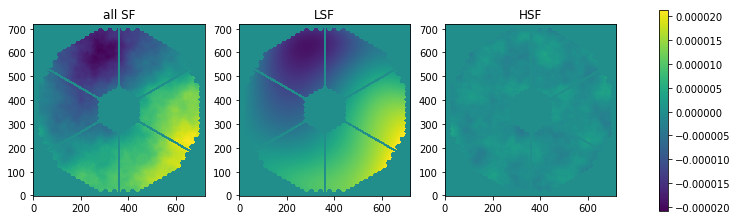

In [8]:
i=0
z=-1
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
plt.subplot(131); im = plt.imshow(cube[i], origin=True); plt.title('all SF')
vmin, vmax = plt.gci().get_clim()
plt.subplot(132); plt.imshow(LSFs[z,i], origin=True, vmin=vmin, vmax=vmax); plt.title('LSF')
plt.subplot(133); plt.imshow(HSFs[z,i], origin=True, vmin=vmin, vmax=vmax); plt.title('HSF')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax);

## 3/ Temporal PSD

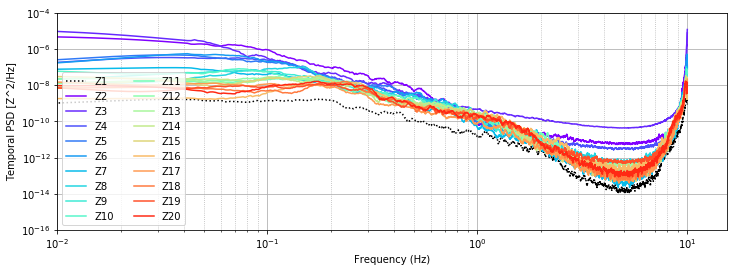

In [9]:
fs = np.arange(ncube)/t_max
Zf = np.abs(np.array([np.fft.fft(Zt) for Zt in zpols.swapaxes(0,1)]))
plt.figure(figsize=(12,4))
plt.grid(True), plt.grid(which='minor', linestyle=':')
plt.loglog()
# Define the colors to be used using rainbow map (or any other map)
colors = np.array([cm.rainbow(i) for i in np.linspace(0, 1, len(Zf))])
warnings.filterwarnings("ignore")
for i,z in enumerate(Zf):
    zhat = savgol_filter(z, win_size, pol_order)
    if i==0:
        plt.plot(fs, zhat**2, ':k', label='Z%s'%(i+1))        
    else:
        plt.plot(fs, zhat**2, color=colors[i-1], label='Z%s'%(i+1))
plt.legend(ncol=2)
plt.xlim(left=1e-2)
plt.ylim((1e-16,1e-4))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Temporal PSD [Z^2/Hz]')
plt.savefig('WV_temp_psd_Z%s.png'%nzers, dpi=300, transparent=True)